## 23 - Memory
>Map based on memory. Create a map of a place you remember—hometown, favorite destination, or somewhere meaningful. It doesn’t need to be perfectly accurate, just how you recall it. 💭🗺️

In [ ]:
import geopandas as gpd
from shapely import Point, LineString, MultiPoint, MultiLineString, Polygon
import osmnx as ox
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.font_manager as font_manager
import matplotlib.patheffects as path_effects
font_manager.fontManager.addfont('../../../../../fonts/pao-halftone-font/PaoHalftone-R9dd6.otf')
from matplotlib.colors import LinearSegmentedColormap
from itertools import combinations

In [ ]:
## getting unique junctions from manually digitized stuff
j = gpd.read_file('junctions.geojson')
j = j.explode().drop(columns='length').reset_index(drop=True)
unique = j['geometry'].unique()
gpd.GeoSeries(unique).to_file('junctions_unique.geojson', driver='GeoJSON')

In [227]:
# getting all roads / paths and exporting
aoi = Polygon([
            [
              -0.4377814986441422,
              50.920047190832065
            ],
            [
              -0.4378956298006358,
              50.94456154852341
            ],
            [
              -0.4751785395632169,
              50.966178920139754
            ],
            [
              -0.4970681439328928,
              50.9955197045779
            ],
            [
              -0.5207937608892337,
              51.00502926599788
            ],
            [
              -0.5466376371444142,
              51.0092945952116
            ],
            [
              -0.5563820495037248,
              51.002629845953436
            ],
            [
              -0.5976192710324426,
              50.998610935572344
            ],
            [
              -0.5990315047071988,
              50.98945565971829
            ],
            [
              -0.6028445766611412,
              50.96829380972184
            ],
            [
              -0.6171081170347179,
              50.935192091465694
            ],
            [
              -0.6238163321402794,
              50.917856715940104
            ],
            [
              -0.6268412976888271,
              50.910369212420505
            ],
            [
              -0.6179904728824965,
              50.902951158087035
            ],
            [
              -0.6001767868703496,
              50.90273919630755
            ],
            [
              -0.5913749648227054,
              50.89709659447254
            ],
            [
              -0.5816827789328158,
              50.89225581213557
            ],
            [
              -0.5810150235720641,
              50.881724442000035
            ],
            [
              -0.5686615493945055,
              50.88151379031268
            ],
            [
              -0.5112345883507885,
              50.89014972857282
            ],
            [
              -0.4427896638510731,
              50.888464793156714
            ],
            [
              -0.4407863977686759,
              50.90657465495653
            ],
            [
              -0.4377814986441422,
              50.920047190832065
            ]
          ])
# paths = ox.features_from_polygon(aoi,
#                                  tags={'highway':True})
# paths.loc['way',['geometry','name']].to_file('true_roads.geojson', driver='GeoJSON')

rail = ox.features_from_polygon(aoi, tags={'railway':'rail'})
river = ox.features_from_polygon(aoi, tags={'waterway':'river'})

river.to_file('true_river.geojson', driver='GeoJSON')
rail.to_file('true_rail.geojson', driver='GeoJSON')

In [389]:
# helper functions
def get_bearing_from_a2b(a, b):
    dx = b.x - a.x
    dy = b.y - a.y
    bearing = np.degrees(np.arctan2(dx, dy))
    bearing += 360
    bearing %= 360
    return bearing

def add_x_eq_y(ax):
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    ax.plot(xlim, ylim, c='k')
    ax.set(xlim=xlim,
           ylim=ylim)

In [ ]:
# read in
origin = gpd.read_file('home_prj.geojson')

my_network = gpd.read_file('paths.geojson')
actual_network = gpd.read_file('true_roads_selection.geojson').to_crs(my_network.crs)

my_points = gpd.read_file('points.geojson')
actual_points = gpd.read_file('true_points.geojson')

my_junctions = gpd.read_file('junctions_unique.geojson').drop(columns=['reality'])
actual_junctions = gpd.read_file('actual_junctions.geojson')

my_river = gpd.read_file('water.geojson')
actual_river = gpd.read_file('true_river.geojson').to_crs(my_network.crs)

my_rail = gpd.read_file('rail.geojson')
actual_rail = gpd.read_file('true_rail.geojson').to_crs(my_network.crs)


Skipping field nodes: unsupported OGR type: 13
Skipping field nodes: unsupported OGR type: 13


In [ ]:
# do the merging of pois and junctions

merged_poi = (actual_points
              .merge(my_points, left_on='what', right_on='what')
              .rename(columns={'geometry_x': 'true_geo',
                               'geometry_y': 'est_geo',
                               })
              )

merged_junctions = (actual_junctions
                    .merge(my_junctions, left_on='pair', right_on='id')
                    .rename(columns={'geometry_x': 'true_geo',
                                     'geometry_y': 'est_geo'})
                    )

merged = pd.concat([merged_poi, merged_junctions])

# calculations
merged['dist_to_true_self'] = merged.apply(
    lambda row: row.true_geo.distance(row.est_geo),
    axis=1)

merged['true_dist_to_home'] = merged.apply(
    lambda row: row.true_geo.distance(origin.loc[0,'geometry'])/1000,
    axis=1)

merged['est_dist_to_home'] = merged.apply(
    lambda row: row.est_geo.distance(origin.loc[0,'geometry'])/1000,
    axis=1)

merged['joining_segment'] = merged.apply(
    lambda row: LineString([row.true_geo, row.est_geo]),
    axis=1)

merged['true_bearing_from_home'] = merged.apply(
    lambda row: get_bearing_from_a2b(origin.loc[0,'geometry'],
                                     row.true_geo),
    axis=1)

merged['est_bearing_from_home'] = merged.apply(
    lambda row: get_bearing_from_a2b(origin.loc[0,'geometry'],
                                     row.est_geo),
    axis=1)

merged['dist_err'] = merged['est_dist_to_home'] - merged['true_dist_to_home']
merged['bear_err'] = merged['est_bearing_from_home'] - merged['true_bearing_from_home']

### plotting

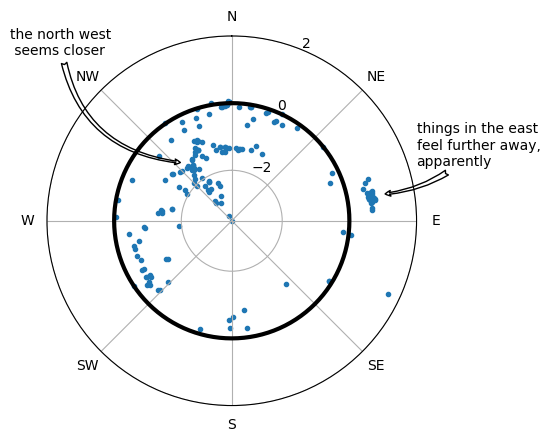

In [ ]:
# polar
fig, ax = plt.subplots(subplot_kw={'projection':'polar'})

ax.set_theta_zero_location('N')
ax.set_theta_direction('clockwise')

ax.scatter(np.radians(merged['true_bearing_from_home']),
           merged['dist_err']/1000,
           marker='.')


ax.plot(np.radians(np.arange(0,360)),
        np.zeros(360),
        linewidth=3, c='k')


ax.set_ylim(*(merged['dist_err']/1000).agg(['min','max']))

ax.set_thetagrids(angles=[0,45,90,135,180,225,270,315],
                  labels=['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']);

ax.set_rgrids([-2, 0, 2])

ax.annotate('things in the east\nfeel further away,\napparently',
            xy=(np.radians(80), 1.05), xycoords='data',
            xytext=(1, 0.65),
            textcoords='axes fraction',
            arrowprops={'arrowstyle':'fancy',
                        'ec':'k',
                        'fc':'none',
                        'connectionstyle':"arc3, rad=-0.2"},
            )

ax.annotate('the north west\n seems closer',
            xy=(np.radians(320), -1.25), xycoords='data',
            xytext=(-0.1, 0.95),
            textcoords='axes fraction',
            arrowprops={'arrowstyle':'fancy',
                        'ec':'k',
                        'fc':'none',
                        'connectionstyle':"arc3, rad=0.4"},
            )

# fig.savefig('polar.png', dpi=300, bbox_inches='tight')

Text(2.5, 6, 'pretty accurate when\nthings are close\nto one another')

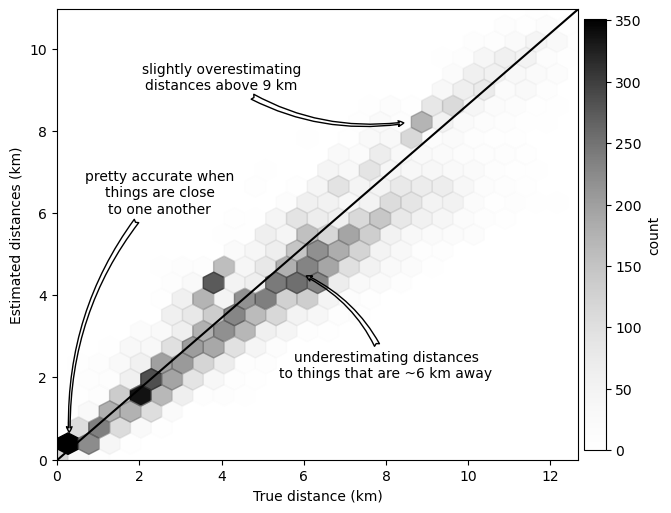

In [387]:
# pairwise distances
true_dists = []
true_bearings = []
for p0, p1 in combinations(merged['true_geo'], 2):
    true_dists.append(p0.distance(p1) / 1000)
    true_bearings.append(get_bearing_from_a2b(p0, p1))

est_dists = []
est_bearings = []
for p0, p1 in combinations(merged['est_geo'], 2):
    est_dists.append(p0.distance(p1) / 1000)
    est_bearings.append(get_bearing_from_a2b(p0, p1))


cmap = LinearSegmentedColormap.from_list(name='dummy', colors=[[1,1,1,0.2], [0,0,0,1]])

fig, ax = plt.subplots(subplot_kw={'aspect':'equal'},
                        # nrows=2,
                        figsize=[8,8])

hb = ax.hexbin(true_dists,
                   est_dists,
                   gridsize=25,
                   cmap=cmap)

add_x_eq_y(ax)

ax.set(xlabel='True distance (km)',
       ylabel='Estimated distances (km)',
       xlim=(0, max(true_dists)),
       ylim=(0, max(est_dists)))

cb1 = fig.colorbar(hb,
                  label='count',
                  shrink=0.7,
                  pad=0.01)

ax.annotate('underestimating distances\nto things that are ~6 km away',
            xy=(6, 4.5),
            xytext=(8,2),
            arrowprops={'arrowstyle':'fancy',
                        'ec':'k',
                        'fc':'none',
                        'connectionstyle':"arc3, rad=0.2"},
                        ha='center')

ax.annotate('slightly overestimating\ndistances above 9 km',
            xy=(8.5, 8.2),
            xytext=(4,9),
            arrowprops={'arrowstyle':'fancy',
                        'ec':'k',
                        'fc':'none',
                        'connectionstyle':"arc3, rad=0.2"},
                        ha='center')

ax.annotate('pretty accurate when\nthings are close\nto one another',
            xy=(0.3, 0.6),
            xytext=(2.5, 6),
            arrowprops={'arrowstyle':'fancy',
                        'ec':'k',
                        'fc':'none',
                        'connectionstyle':"arc3, rad=0.2"},
                        ha='center')

# fig.savefig('distances.png', dpi=300, bbox_inches='tight')

Text(0.5, 0.73, 'memory\nlanes')

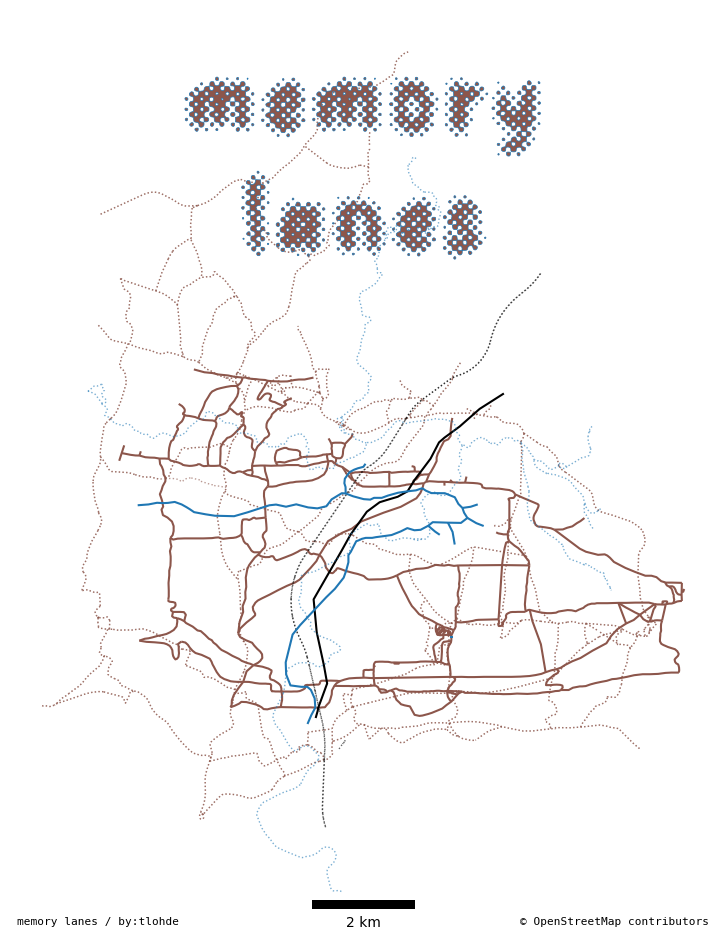

In [388]:
## the map
fig, ax =plt.subplots(subplot_kw={'aspect':'equal'},
                       figsize=[12,12],
                       )

my_network.plot(ax=ax, color='tab:brown')
actual_network.plot(ax=ax, color='tab:brown', alpha=0.6, linestyle=':', linewidth=1)

my_rail.plot(ax=ax, color='k')
actual_rail.plot(ax=ax, color='k', alpha=0.6, linestyle=':', linewidth=1)


my_river.plot(ax=ax, color='tab:blue')
actual_river.plot(ax=ax, color='tab:blue', alpha=0.6, linestyle=':', linewidth=1)

ax.set_axis_off()

ax.add_artist(ScaleBar(1, location='lower center'))

ax.annotate('memory lanes / by:tlohde',
            xy=(0.01, 0.01),
            xycoords='axes fraction',
            font='DejaVu Sans Mono',
            fontsize=8)

ax.annotate('© OpenStreetMap contributors',
            xy=(0.99, 0.01),
            xycoords='axes fraction',
            font='DejaVu Sans Mono',
            ha='right',
            fontsize=8)

ax.set_title('memory\nlanes', font='Pao Halftone', fontsize=80,
            y=0.73,
            color='tab:brown',
            path_effects=[path_effects.Stroke(linewidth=0.5, foreground='tab:blue')]
             )

# fig.savefig('day23.png', dpi=300, bbox_inches='tight')